# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

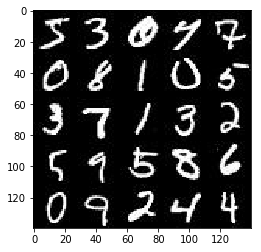

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

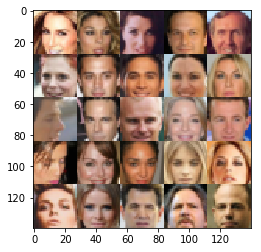

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name='inputs_real')
    inputs_z = tf.placeholder(tf.float32, [None, z_dim], name='inputs_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "C:\\Users\\toile\\Anaconda3\\envs\\tensorflow-gpu\\lib\\runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "C:\\Users\\toile\\Anaconda3\\envs\\tensorflow-gpu\\lib\\runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "C:\\Users\\toile\\Anaconda3\\envs\\tensorflow-gpu\\lib\\site-packages\\ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "C:\\Users\\toile\\Anaconda3\\envs\\tensorflow-gpu\\lib\\site-packages\\traitlets\\config\\application.py", line 658, in launch_instance\n    app.start()', 'File "C:\\Users\\toile\\Anaconda3\\envs\\tensorflow-gpu\\lib\\site-packages\\ipykernel\\kernelapp.py", line 477, in start\n    ioloo

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        # input is 28x28x1 or 28x28x3
        
        # try different weight initializer
        # w_init = tf.contrib.layers.variance_scaling_initializer()
        # w_init = tf.truncated_normal_initializer(stddev=0.02)
        w_init = tf.contrib.layers.xavier_initializer()
        # w_init_conv2d = tf.contrib.layers.xavier_initializer()
        # w_init_dense = tf.contrib.layers.xavier_initializer()
        
        # for leaky ReLU
        alpha = 0.2
        
        # make 14x14x64
        filters = 64
        x1 = tf.layers.conv2d(inputs=images, 
                              filters=filters, 
                              kernel_size=5, 
                              strides=2, 
                              padding='same', 
                              activation=None, 
                              kernel_initializer=w_init)
        x1 = tf.maximum(alpha * x1, x1)
        
        # make 7x7x128
        filters = filters * 2
        x2 = tf.layers.conv2d(inputs=x1, 
                              filters=filters, 
                              kernel_size=5, 
                              strides=2, 
                              padding='same', 
                              activation=None, 
                              kernel_initializer=w_init)
        x2 = tf.layers.batch_normalization(inputs=x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)
        
        # make 4x4x256
        filters = filters * 2
        x3 = tf.layers.conv2d(inputs=x2, 
                              filters=filters, 
                              kernel_size=5, 
                              strides=2, 
                              padding='same', 
                              activation=None, 
                              kernel_initializer=w_init)
        x3 = tf.layers.batch_normalization(inputs=x3, training=True)
        x3 = tf.maximum(alpha * x3, x3)
        
        # flatten the layer
        flattend_layer = tf.reshape(tensor=x3, shape=[-1, 4*4*filters])
        logits = tf.layers.dense(inputs=flattend_layer, 
                                 units=1, 
                                 activation=None, 
                                 use_bias=True, 
                                 kernel_initializer=w_init)
        out = tf.sigmoid(logits)
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    reuse = False if is_train == True else True
    with tf.variable_scope('generator', reuse=reuse):
        # input is z_dim
        
        # try different weight initializer
        # w_init = tf.contrib.layers.variance_scaling_initializer()
        # w_init = tf.truncated_normal_initializer(stddev=0.02)
        w_init = tf.contrib.layers.xavier_initializer()
        # w_init_conv2d = tf.contrib.layers.xavier_initializer()
        # w_init_dense = tf.contrib.layers.xavier_initializer()
        
        # for leaky ReLU
        alpha = 0.2
        
        # 1. Fully connected layer (make 3x3x512) & reshape to prepare first layer
        feature_map_size = 512
        x1 = tf.layers.dense(inputs=z, 
                             units=3*3*feature_map_size, 
                             activation=None, 
                             use_bias=True, 
                             kernel_initializer=w_init)
        x1 = tf.reshape(tensor=x1, shape=[-1, 3, 3, feature_map_size])
        x1 = tf.layers.batch_normalization(inputs=x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        
        # 2. deconvolutional layer (make 7x7x256)
        # kernel size & padding should be 3 & 'valid' to make output layer it 7x7x256
        # this is neccessary to make final layer 28x28x?
        feature_map_size = feature_map_size // 2
        x2 = tf.layers.conv2d_transpose(inputs=x1, 
                                        filters=feature_map_size, 
                                        kernel_size=3, 
                                        strides=2, 
                                        padding='valid', 
                                        activation=None, 
                                        kernel_initializer=w_init)
        x2 = tf.layers.batch_normalization(inputs=x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        
        # 3. deconvolutional layer (make 14x14x128)
        feature_map_size = feature_map_size // 2
        x3 = tf.layers.conv2d_transpose(inputs=x2, 
                                        filters=feature_map_size, 
                                        kernel_size=5, 
                                        strides=2, 
                                        padding='same', 
                                        activation=None, 
                                        kernel_initializer=w_init)
        x3 = tf.layers.batch_normalization(inputs=x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        
        # 4. Output layer, 28x28x1 or 28x28x3
        logits = tf.layers.conv2d_transpose(inputs=x3, 
                                            filters=out_channel_dim, 
                                            kernel_size=5, 
                                            strides=2, 
                                            padding='same', 
                                            activation=None,
                                            kernel_initializer=w_init)
        out = tf.tanh(logits)
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # build each model
    g_model = generator(input_z, out_channel_dim=out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    # loss compuation graph
    smooth = 0.1
    d_real_label = tf.ones_like(d_logits_real) * (1 - smooth)
    d_fake_label = tf.zeros_like(d_logits_real)
    d_loss_real = tf.reduce_mean( tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=d_real_label) )
    d_loss_fake = tf.reduce_mean( tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=d_fake_label) )
    d_loss = d_loss_real + d_loss_fake
    
    g_label = tf.ones_like(d_logits_fake)
    g_loss = tf.reduce_mean( tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=g_label) )
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # get each trainable variables
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    # optimaization graph
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data ==> [number_of_images, width, height, channel]
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """    
    # get input place holders
    input_real, input_z, input_learning_rate = model_inputs(image_width=data_shape[1], 
                                                            image_height=data_shape[2], 
                                                            image_channels=data_shape[3], 
                                                            z_dim=z_dim)
    
    # build model
    d_loss, g_loss = model_loss(input_real=input_real, input_z=input_z, out_channel_dim=data_shape[3])
    
    # build optimizer
    d_train_opt, g_train_opt = model_opt(d_loss=d_loss, g_loss=g_loss, learning_rate=input_learning_rate, beta1=beta1)
    
    steps = 0
    print_every = 10
    show_every = 100
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps = steps + 1
                
                # make image range between -1 ~ 1
                batch_images = batch_images * 2
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, input_learning_rate: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z, input_real: batch_images, input_learning_rate: learning_rate})
                #_ = sess.run(g_train_opt, feed_dict={input_z: batch_z, input_real: batch_images, input_learning_rate: learning_rate})
                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                if steps % show_every == 0:        
                    show_generator_output(sess, show_n_images, input_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.5405... Generator Loss: 2.2043
Epoch 1/2... Discriminator Loss: 0.8547... Generator Loss: 5.7738
Epoch 1/2... Discriminator Loss: 1.1346... Generator Loss: 1.3162
Epoch 1/2... Discriminator Loss: 0.9033... Generator Loss: 1.1698
Epoch 1/2... Discriminator Loss: 1.1125... Generator Loss: 1.5672
Epoch 1/2... Discriminator Loss: 0.6211... Generator Loss: 1.7240
Epoch 1/2... Discriminator Loss: 0.6796... Generator Loss: 1.5602
Epoch 1/2... Discriminator Loss: 0.9313... Generator Loss: 1.0992
Epoch 1/2... Discriminator Loss: 0.5887... Generator Loss: 2.3073
Epoch 1/2... Discriminator Loss: 0.6138... Generator Loss: 1.8999


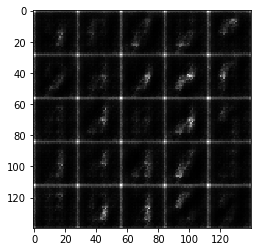

Epoch 1/2... Discriminator Loss: 0.5765... Generator Loss: 2.3616
Epoch 1/2... Discriminator Loss: 0.6337... Generator Loss: 3.2049
Epoch 1/2... Discriminator Loss: 0.7135... Generator Loss: 1.8186
Epoch 1/2... Discriminator Loss: 1.0185... Generator Loss: 2.6466
Epoch 1/2... Discriminator Loss: 0.7997... Generator Loss: 1.5953
Epoch 1/2... Discriminator Loss: 0.8811... Generator Loss: 1.7285
Epoch 1/2... Discriminator Loss: 0.9917... Generator Loss: 1.2521
Epoch 1/2... Discriminator Loss: 0.7590... Generator Loss: 1.9116
Epoch 1/2... Discriminator Loss: 1.2668... Generator Loss: 0.8424
Epoch 1/2... Discriminator Loss: 0.8171... Generator Loss: 1.5218


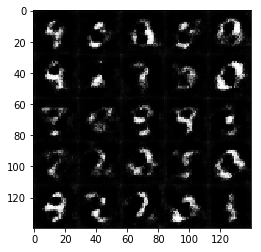

Epoch 1/2... Discriminator Loss: 0.8282... Generator Loss: 1.2996
Epoch 1/2... Discriminator Loss: 0.8555... Generator Loss: 1.4020
Epoch 1/2... Discriminator Loss: 0.8463... Generator Loss: 1.3625
Epoch 1/2... Discriminator Loss: 0.8538... Generator Loss: 1.2515
Epoch 1/2... Discriminator Loss: 1.0063... Generator Loss: 0.9908
Epoch 1/2... Discriminator Loss: 0.7735... Generator Loss: 1.4152
Epoch 1/2... Discriminator Loss: 0.8359... Generator Loss: 1.9140
Epoch 1/2... Discriminator Loss: 0.9075... Generator Loss: 1.7631
Epoch 1/2... Discriminator Loss: 1.2788... Generator Loss: 0.7055
Epoch 1/2... Discriminator Loss: 0.9475... Generator Loss: 2.2721


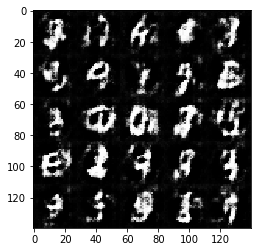

Epoch 1/2... Discriminator Loss: 0.8424... Generator Loss: 1.1807
Epoch 1/2... Discriminator Loss: 0.9285... Generator Loss: 1.4893
Epoch 1/2... Discriminator Loss: 0.7517... Generator Loss: 1.3502
Epoch 1/2... Discriminator Loss: 0.8436... Generator Loss: 1.2423
Epoch 1/2... Discriminator Loss: 0.7352... Generator Loss: 1.6257
Epoch 1/2... Discriminator Loss: 1.0685... Generator Loss: 0.7936
Epoch 1/2... Discriminator Loss: 0.7486... Generator Loss: 1.4329
Epoch 1/2... Discriminator Loss: 0.6072... Generator Loss: 1.9701
Epoch 1/2... Discriminator Loss: 0.7896... Generator Loss: 1.5517
Epoch 1/2... Discriminator Loss: 1.0015... Generator Loss: 0.9385


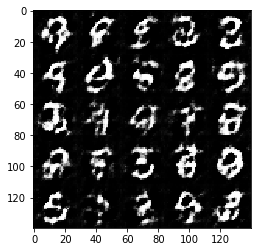

Epoch 1/2... Discriminator Loss: 0.9201... Generator Loss: 2.7714
Epoch 1/2... Discriminator Loss: 0.7288... Generator Loss: 1.5153
Epoch 1/2... Discriminator Loss: 0.7300... Generator Loss: 2.1334
Epoch 1/2... Discriminator Loss: 0.6864... Generator Loss: 1.4584
Epoch 1/2... Discriminator Loss: 0.6442... Generator Loss: 1.8376
Epoch 1/2... Discriminator Loss: 0.7184... Generator Loss: 1.9275
Epoch 1/2... Discriminator Loss: 0.7424... Generator Loss: 1.8849
Epoch 1/2... Discriminator Loss: 0.7355... Generator Loss: 1.6166
Epoch 1/2... Discriminator Loss: 0.7396... Generator Loss: 1.4350
Epoch 1/2... Discriminator Loss: 0.7210... Generator Loss: 1.3856


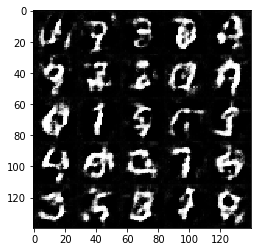

Epoch 1/2... Discriminator Loss: 0.7652... Generator Loss: 1.7365
Epoch 1/2... Discriminator Loss: 0.7284... Generator Loss: 1.5375
Epoch 1/2... Discriminator Loss: 0.8285... Generator Loss: 2.7288
Epoch 1/2... Discriminator Loss: 0.6677... Generator Loss: 1.6670
Epoch 1/2... Discriminator Loss: 0.7872... Generator Loss: 2.5365
Epoch 1/2... Discriminator Loss: 1.1865... Generator Loss: 0.7782
Epoch 1/2... Discriminator Loss: 1.0282... Generator Loss: 0.7905
Epoch 1/2... Discriminator Loss: 0.8842... Generator Loss: 1.0849
Epoch 1/2... Discriminator Loss: 0.9062... Generator Loss: 1.0308
Epoch 1/2... Discriminator Loss: 0.8927... Generator Loss: 2.3671


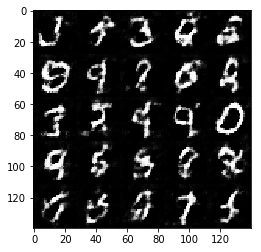

Epoch 1/2... Discriminator Loss: 0.7654... Generator Loss: 2.0291
Epoch 1/2... Discriminator Loss: 0.9353... Generator Loss: 2.2832
Epoch 1/2... Discriminator Loss: 0.7911... Generator Loss: 1.2460
Epoch 1/2... Discriminator Loss: 0.6362... Generator Loss: 1.8129
Epoch 1/2... Discriminator Loss: 0.9424... Generator Loss: 1.7702
Epoch 1/2... Discriminator Loss: 1.4320... Generator Loss: 0.5680
Epoch 1/2... Discriminator Loss: 0.7178... Generator Loss: 1.9025
Epoch 1/2... Discriminator Loss: 1.0293... Generator Loss: 0.9310
Epoch 1/2... Discriminator Loss: 0.7286... Generator Loss: 1.6721
Epoch 1/2... Discriminator Loss: 0.8156... Generator Loss: 1.7419


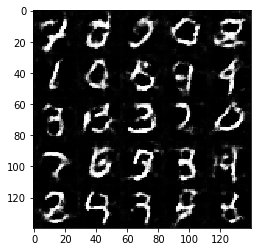

Epoch 1/2... Discriminator Loss: 1.3982... Generator Loss: 0.7309
Epoch 1/2... Discriminator Loss: 0.9018... Generator Loss: 1.1084
Epoch 1/2... Discriminator Loss: 0.8724... Generator Loss: 1.9109
Epoch 1/2... Discriminator Loss: 0.6582... Generator Loss: 1.9820
Epoch 1/2... Discriminator Loss: 0.7580... Generator Loss: 1.3814
Epoch 1/2... Discriminator Loss: 0.7587... Generator Loss: 1.2493
Epoch 1/2... Discriminator Loss: 0.7577... Generator Loss: 2.0885
Epoch 1/2... Discriminator Loss: 0.8483... Generator Loss: 1.1443
Epoch 1/2... Discriminator Loss: 0.8073... Generator Loss: 1.7830
Epoch 1/2... Discriminator Loss: 0.9028... Generator Loss: 1.0044


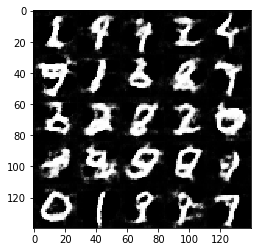

Epoch 1/2... Discriminator Loss: 0.9171... Generator Loss: 1.1491
Epoch 1/2... Discriminator Loss: 0.8850... Generator Loss: 1.1173
Epoch 1/2... Discriminator Loss: 0.8355... Generator Loss: 1.2098
Epoch 1/2... Discriminator Loss: 0.6333... Generator Loss: 1.8165
Epoch 1/2... Discriminator Loss: 0.7552... Generator Loss: 1.3992
Epoch 1/2... Discriminator Loss: 1.5528... Generator Loss: 0.6619
Epoch 1/2... Discriminator Loss: 0.9019... Generator Loss: 1.4831
Epoch 1/2... Discriminator Loss: 0.7591... Generator Loss: 1.4902
Epoch 1/2... Discriminator Loss: 0.9179... Generator Loss: 2.3172
Epoch 1/2... Discriminator Loss: 0.7527... Generator Loss: 1.4219


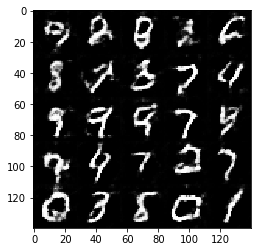

Epoch 1/2... Discriminator Loss: 0.9144... Generator Loss: 0.9707
Epoch 1/2... Discriminator Loss: 0.7681... Generator Loss: 1.3840
Epoch 1/2... Discriminator Loss: 1.0448... Generator Loss: 0.8140
Epoch 2/2... Discriminator Loss: 0.7651... Generator Loss: 1.3030
Epoch 2/2... Discriminator Loss: 0.6545... Generator Loss: 2.0559
Epoch 2/2... Discriminator Loss: 0.7242... Generator Loss: 1.5309
Epoch 2/2... Discriminator Loss: 0.8600... Generator Loss: 1.2243
Epoch 2/2... Discriminator Loss: 0.8728... Generator Loss: 1.3364
Epoch 2/2... Discriminator Loss: 0.8459... Generator Loss: 1.4823
Epoch 2/2... Discriminator Loss: 1.0425... Generator Loss: 0.8477


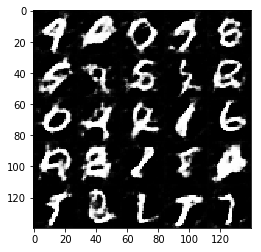

Epoch 2/2... Discriminator Loss: 0.8781... Generator Loss: 1.2562
Epoch 2/2... Discriminator Loss: 0.6631... Generator Loss: 1.9390
Epoch 2/2... Discriminator Loss: 0.7369... Generator Loss: 1.5407
Epoch 2/2... Discriminator Loss: 0.8886... Generator Loss: 1.0009
Epoch 2/2... Discriminator Loss: 0.6579... Generator Loss: 1.9242
Epoch 2/2... Discriminator Loss: 1.0146... Generator Loss: 0.8930
Epoch 2/2... Discriminator Loss: 0.7197... Generator Loss: 1.5332
Epoch 2/2... Discriminator Loss: 1.0528... Generator Loss: 0.8106
Epoch 2/2... Discriminator Loss: 0.7003... Generator Loss: 1.6317
Epoch 2/2... Discriminator Loss: 1.0178... Generator Loss: 0.8244


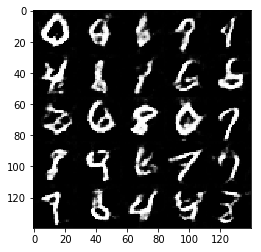

Epoch 2/2... Discriminator Loss: 0.6383... Generator Loss: 1.8000
Epoch 2/2... Discriminator Loss: 0.6631... Generator Loss: 1.9286
Epoch 2/2... Discriminator Loss: 0.5935... Generator Loss: 2.0608
Epoch 2/2... Discriminator Loss: 0.6800... Generator Loss: 1.7117
Epoch 2/2... Discriminator Loss: 0.6694... Generator Loss: 1.5659
Epoch 2/2... Discriminator Loss: 1.3914... Generator Loss: 0.4857
Epoch 2/2... Discriminator Loss: 0.8682... Generator Loss: 1.4236
Epoch 2/2... Discriminator Loss: 0.8832... Generator Loss: 1.0187
Epoch 2/2... Discriminator Loss: 0.6703... Generator Loss: 1.8187
Epoch 2/2... Discriminator Loss: 0.6607... Generator Loss: 1.5360


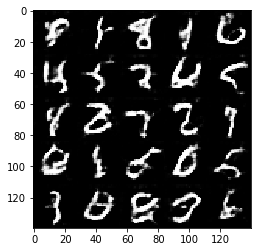

Epoch 2/2... Discriminator Loss: 0.8316... Generator Loss: 2.9970
Epoch 2/2... Discriminator Loss: 0.7547... Generator Loss: 1.4450
Epoch 2/2... Discriminator Loss: 0.8757... Generator Loss: 1.0147
Epoch 2/2... Discriminator Loss: 0.8486... Generator Loss: 1.1520
Epoch 2/2... Discriminator Loss: 0.8479... Generator Loss: 2.1233
Epoch 2/2... Discriminator Loss: 0.7117... Generator Loss: 1.5149
Epoch 2/2... Discriminator Loss: 0.7631... Generator Loss: 1.2271
Epoch 2/2... Discriminator Loss: 0.8714... Generator Loss: 1.1017
Epoch 2/2... Discriminator Loss: 0.7215... Generator Loss: 1.7973
Epoch 2/2... Discriminator Loss: 0.8567... Generator Loss: 1.9706


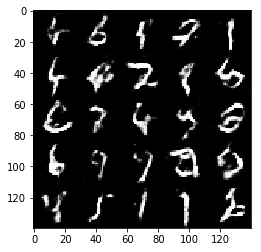

Epoch 2/2... Discriminator Loss: 0.7275... Generator Loss: 1.3978
Epoch 2/2... Discriminator Loss: 1.0785... Generator Loss: 0.8097
Epoch 2/2... Discriminator Loss: 0.7159... Generator Loss: 1.6407
Epoch 2/2... Discriminator Loss: 0.6329... Generator Loss: 1.8852
Epoch 2/2... Discriminator Loss: 0.9003... Generator Loss: 1.0029
Epoch 2/2... Discriminator Loss: 1.0801... Generator Loss: 0.7777
Epoch 2/2... Discriminator Loss: 0.7386... Generator Loss: 1.3683
Epoch 2/2... Discriminator Loss: 0.6940... Generator Loss: 1.7273
Epoch 2/2... Discriminator Loss: 0.6769... Generator Loss: 1.9803
Epoch 2/2... Discriminator Loss: 1.8799... Generator Loss: 3.3965


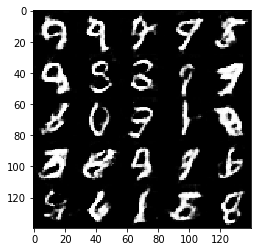

Epoch 2/2... Discriminator Loss: 0.7932... Generator Loss: 1.2870
Epoch 2/2... Discriminator Loss: 0.8360... Generator Loss: 1.1104
Epoch 2/2... Discriminator Loss: 0.8069... Generator Loss: 1.1213
Epoch 2/2... Discriminator Loss: 0.6258... Generator Loss: 1.6476
Epoch 2/2... Discriminator Loss: 0.7346... Generator Loss: 1.4493
Epoch 2/2... Discriminator Loss: 0.8293... Generator Loss: 1.1392
Epoch 2/2... Discriminator Loss: 0.7129... Generator Loss: 1.4811
Epoch 2/2... Discriminator Loss: 0.7516... Generator Loss: 1.2879
Epoch 2/2... Discriminator Loss: 0.6192... Generator Loss: 2.0494
Epoch 2/2... Discriminator Loss: 0.7565... Generator Loss: 2.0244


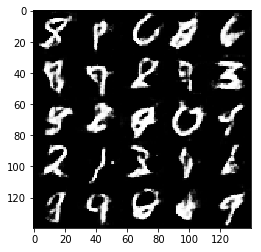

Epoch 2/2... Discriminator Loss: 0.8287... Generator Loss: 1.1339
Epoch 2/2... Discriminator Loss: 0.6814... Generator Loss: 1.4605
Epoch 2/2... Discriminator Loss: 0.6313... Generator Loss: 1.6233
Epoch 2/2... Discriminator Loss: 0.6326... Generator Loss: 1.5903
Epoch 2/2... Discriminator Loss: 0.7468... Generator Loss: 1.2575
Epoch 2/2... Discriminator Loss: 0.7558... Generator Loss: 2.4523
Epoch 2/2... Discriminator Loss: 0.9338... Generator Loss: 1.0162
Epoch 2/2... Discriminator Loss: 0.7888... Generator Loss: 1.2645
Epoch 2/2... Discriminator Loss: 0.8575... Generator Loss: 1.1055
Epoch 2/2... Discriminator Loss: 0.8734... Generator Loss: 1.5387


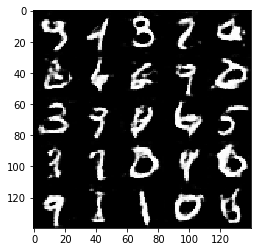

Epoch 2/2... Discriminator Loss: 1.0734... Generator Loss: 0.7596
Epoch 2/2... Discriminator Loss: 1.3005... Generator Loss: 2.7190
Epoch 2/2... Discriminator Loss: 1.3488... Generator Loss: 2.6065
Epoch 2/2... Discriminator Loss: 0.9630... Generator Loss: 1.0648
Epoch 2/2... Discriminator Loss: 0.8427... Generator Loss: 1.0681
Epoch 2/2... Discriminator Loss: 0.6508... Generator Loss: 1.4775
Epoch 2/2... Discriminator Loss: 0.6230... Generator Loss: 1.6410
Epoch 2/2... Discriminator Loss: 0.6619... Generator Loss: 1.6218
Epoch 2/2... Discriminator Loss: 0.6458... Generator Loss: 1.7723
Epoch 2/2... Discriminator Loss: 1.0227... Generator Loss: 0.8158


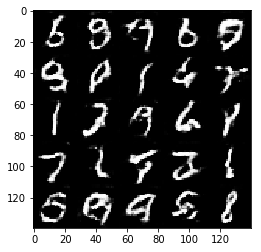

Epoch 2/2... Discriminator Loss: 2.0222... Generator Loss: 0.3447
Epoch 2/2... Discriminator Loss: 0.8727... Generator Loss: 1.0709
Epoch 2/2... Discriminator Loss: 2.0473... Generator Loss: 0.4054
Epoch 2/2... Discriminator Loss: 0.8458... Generator Loss: 1.1420
Epoch 2/2... Discriminator Loss: 0.6972... Generator Loss: 2.0449
Epoch 2/2... Discriminator Loss: 0.6639... Generator Loss: 1.6580
Epoch 2/2... Discriminator Loss: 0.6817... Generator Loss: 1.7939
Epoch 2/2... Discriminator Loss: 1.6726... Generator Loss: 0.4620
Epoch 2/2... Discriminator Loss: 0.5662... Generator Loss: 2.1298
Epoch 2/2... Discriminator Loss: 0.9486... Generator Loss: 1.1091


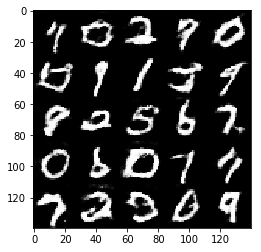

Epoch 2/2... Discriminator Loss: 1.0477... Generator Loss: 1.6680
Epoch 2/2... Discriminator Loss: 1.0435... Generator Loss: 0.9806
Epoch 2/2... Discriminator Loss: 0.7404... Generator Loss: 1.5037
Epoch 2/2... Discriminator Loss: 0.7092... Generator Loss: 1.4679
Epoch 2/2... Discriminator Loss: 0.7807... Generator Loss: 1.4201
Epoch 2/2... Discriminator Loss: 0.6537... Generator Loss: 1.8474
Epoch 2/2... Discriminator Loss: 0.8823... Generator Loss: 1.1124


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.8460... Generator Loss: 1.1105
Epoch 1/1... Discriminator Loss: 0.7910... Generator Loss: 1.2924
Epoch 1/1... Discriminator Loss: 0.6115... Generator Loss: 2.0024
Epoch 1/1... Discriminator Loss: 0.4242... Generator Loss: 3.0065
Epoch 1/1... Discriminator Loss: 0.3850... Generator Loss: 4.2783
Epoch 1/1... Discriminator Loss: 0.9987... Generator Loss: 0.9814
Epoch 1/1... Discriminator Loss: 1.1230... Generator Loss: 1.2602
Epoch 1/1... Discriminator Loss: 1.5223... Generator Loss: 0.4445
Epoch 1/1... Discriminator Loss: 0.8137... Generator Loss: 2.3042
Epoch 1/1... Discriminator Loss: 1.6290... Generator Loss: 5.0314


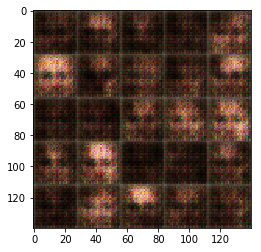

Epoch 1/1... Discriminator Loss: 0.8634... Generator Loss: 1.2576
Epoch 1/1... Discriminator Loss: 0.8806... Generator Loss: 4.1657
Epoch 1/1... Discriminator Loss: 0.8685... Generator Loss: 3.0775
Epoch 1/1... Discriminator Loss: 0.6962... Generator Loss: 1.6556
Epoch 1/1... Discriminator Loss: 0.8639... Generator Loss: 5.0980
Epoch 1/1... Discriminator Loss: 0.8855... Generator Loss: 1.3428
Epoch 1/1... Discriminator Loss: 1.1873... Generator Loss: 0.7121
Epoch 1/1... Discriminator Loss: 0.6288... Generator Loss: 2.4582
Epoch 1/1... Discriminator Loss: 0.8758... Generator Loss: 1.2009
Epoch 1/1... Discriminator Loss: 0.7869... Generator Loss: 1.4149


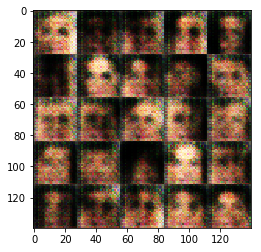

Epoch 1/1... Discriminator Loss: 0.5557... Generator Loss: 2.9287
Epoch 1/1... Discriminator Loss: 1.4705... Generator Loss: 4.7866
Epoch 1/1... Discriminator Loss: 0.7644... Generator Loss: 1.3582
Epoch 1/1... Discriminator Loss: 0.7023... Generator Loss: 1.5189
Epoch 1/1... Discriminator Loss: 0.8043... Generator Loss: 1.4795
Epoch 1/1... Discriminator Loss: 1.2587... Generator Loss: 0.6126
Epoch 1/1... Discriminator Loss: 1.2225... Generator Loss: 0.8820
Epoch 1/1... Discriminator Loss: 0.9008... Generator Loss: 1.1307
Epoch 1/1... Discriminator Loss: 1.0469... Generator Loss: 1.0200
Epoch 1/1... Discriminator Loss: 1.7903... Generator Loss: 4.7064


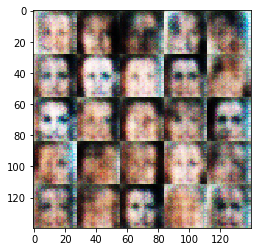

Epoch 1/1... Discriminator Loss: 0.9183... Generator Loss: 2.0118
Epoch 1/1... Discriminator Loss: 0.7065... Generator Loss: 1.7328
Epoch 1/1... Discriminator Loss: 0.7866... Generator Loss: 1.3809
Epoch 1/1... Discriminator Loss: 1.0574... Generator Loss: 0.7932
Epoch 1/1... Discriminator Loss: 1.0757... Generator Loss: 0.7736
Epoch 1/1... Discriminator Loss: 0.8302... Generator Loss: 1.5800
Epoch 1/1... Discriminator Loss: 1.5503... Generator Loss: 0.4258
Epoch 1/1... Discriminator Loss: 0.6291... Generator Loss: 2.0756
Epoch 1/1... Discriminator Loss: 0.5541... Generator Loss: 2.7714
Epoch 1/1... Discriminator Loss: 0.6182... Generator Loss: 2.4238


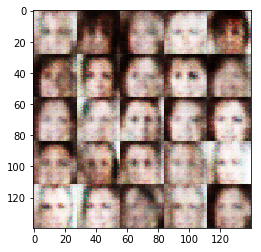

Epoch 1/1... Discriminator Loss: 2.2115... Generator Loss: 0.2519
Epoch 1/1... Discriminator Loss: 0.9112... Generator Loss: 1.2709
Epoch 1/1... Discriminator Loss: 0.8604... Generator Loss: 1.8052
Epoch 1/1... Discriminator Loss: 0.8220... Generator Loss: 1.6316
Epoch 1/1... Discriminator Loss: 0.8060... Generator Loss: 1.3728
Epoch 1/1... Discriminator Loss: 0.7733... Generator Loss: 1.3715
Epoch 1/1... Discriminator Loss: 0.8891... Generator Loss: 1.7112
Epoch 1/1... Discriminator Loss: 1.1395... Generator Loss: 0.8220
Epoch 1/1... Discriminator Loss: 1.4750... Generator Loss: 0.5100
Epoch 1/1... Discriminator Loss: 0.6512... Generator Loss: 1.9090


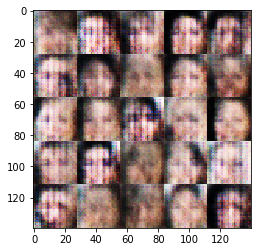

Epoch 1/1... Discriminator Loss: 1.1871... Generator Loss: 0.7397
Epoch 1/1... Discriminator Loss: 0.7556... Generator Loss: 1.5989
Epoch 1/1... Discriminator Loss: 1.2111... Generator Loss: 0.7107
Epoch 1/1... Discriminator Loss: 1.1004... Generator Loss: 0.8683
Epoch 1/1... Discriminator Loss: 0.8143... Generator Loss: 2.0551
Epoch 1/1... Discriminator Loss: 0.7142... Generator Loss: 1.7824
Epoch 1/1... Discriminator Loss: 0.6628... Generator Loss: 1.9446
Epoch 1/1... Discriminator Loss: 0.9216... Generator Loss: 1.6269
Epoch 1/1... Discriminator Loss: 0.7728... Generator Loss: 1.8081
Epoch 1/1... Discriminator Loss: 0.9181... Generator Loss: 1.1627


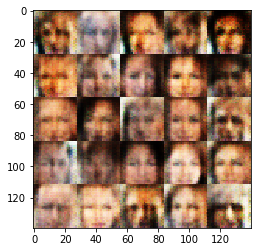

Epoch 1/1... Discriminator Loss: 0.8371... Generator Loss: 1.2848
Epoch 1/1... Discriminator Loss: 1.0169... Generator Loss: 1.4105
Epoch 1/1... Discriminator Loss: 0.7437... Generator Loss: 2.7330
Epoch 1/1... Discriminator Loss: 0.8284... Generator Loss: 1.7087
Epoch 1/1... Discriminator Loss: 0.8351... Generator Loss: 2.0606
Epoch 1/1... Discriminator Loss: 0.9434... Generator Loss: 1.5045
Epoch 1/1... Discriminator Loss: 0.9812... Generator Loss: 1.0282
Epoch 1/1... Discriminator Loss: 1.2130... Generator Loss: 0.6725
Epoch 1/1... Discriminator Loss: 0.9842... Generator Loss: 1.3528
Epoch 1/1... Discriminator Loss: 0.9916... Generator Loss: 1.0828


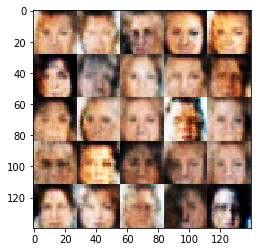

Epoch 1/1... Discriminator Loss: 0.8105... Generator Loss: 1.4396
Epoch 1/1... Discriminator Loss: 0.8116... Generator Loss: 1.7738
Epoch 1/1... Discriminator Loss: 1.0860... Generator Loss: 0.7615
Epoch 1/1... Discriminator Loss: 0.9292... Generator Loss: 1.1294
Epoch 1/1... Discriminator Loss: 0.7878... Generator Loss: 1.5502
Epoch 1/1... Discriminator Loss: 0.9875... Generator Loss: 0.9296
Epoch 1/1... Discriminator Loss: 0.9985... Generator Loss: 1.2944
Epoch 1/1... Discriminator Loss: 1.4071... Generator Loss: 3.0761
Epoch 1/1... Discriminator Loss: 1.0589... Generator Loss: 2.1093
Epoch 1/1... Discriminator Loss: 0.8392... Generator Loss: 1.2493


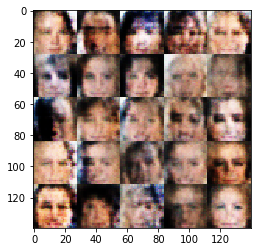

Epoch 1/1... Discriminator Loss: 0.9804... Generator Loss: 0.9282
Epoch 1/1... Discriminator Loss: 1.1892... Generator Loss: 0.7269
Epoch 1/1... Discriminator Loss: 0.9446... Generator Loss: 1.0902
Epoch 1/1... Discriminator Loss: 0.8751... Generator Loss: 1.4332
Epoch 1/1... Discriminator Loss: 0.9840... Generator Loss: 1.1299
Epoch 1/1... Discriminator Loss: 0.7426... Generator Loss: 1.5489
Epoch 1/1... Discriminator Loss: 0.9175... Generator Loss: 1.1453
Epoch 1/1... Discriminator Loss: 1.0045... Generator Loss: 0.9933
Epoch 1/1... Discriminator Loss: 1.1797... Generator Loss: 2.0375
Epoch 1/1... Discriminator Loss: 1.1203... Generator Loss: 0.7740


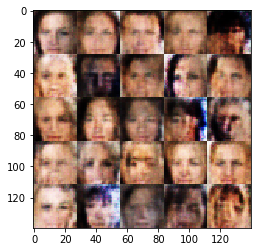

Epoch 1/1... Discriminator Loss: 0.8985... Generator Loss: 1.1882
Epoch 1/1... Discriminator Loss: 0.9739... Generator Loss: 1.1043
Epoch 1/1... Discriminator Loss: 0.8281... Generator Loss: 1.2618
Epoch 1/1... Discriminator Loss: 1.2458... Generator Loss: 1.8530
Epoch 1/1... Discriminator Loss: 0.9989... Generator Loss: 1.7448
Epoch 1/1... Discriminator Loss: 0.8516... Generator Loss: 1.2947
Epoch 1/1... Discriminator Loss: 0.7973... Generator Loss: 1.5522
Epoch 1/1... Discriminator Loss: 1.1328... Generator Loss: 1.0907
Epoch 1/1... Discriminator Loss: 0.8938... Generator Loss: 1.5010
Epoch 1/1... Discriminator Loss: 0.9757... Generator Loss: 1.1066


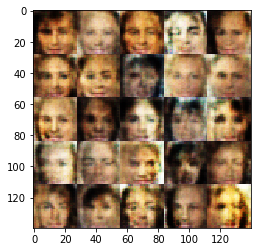

Epoch 1/1... Discriminator Loss: 1.0236... Generator Loss: 0.8285
Epoch 1/1... Discriminator Loss: 1.0962... Generator Loss: 0.8715
Epoch 1/1... Discriminator Loss: 1.3501... Generator Loss: 0.5365
Epoch 1/1... Discriminator Loss: 0.9443... Generator Loss: 1.2336
Epoch 1/1... Discriminator Loss: 0.8802... Generator Loss: 1.2784
Epoch 1/1... Discriminator Loss: 0.9340... Generator Loss: 1.2153
Epoch 1/1... Discriminator Loss: 0.9723... Generator Loss: 2.1678
Epoch 1/1... Discriminator Loss: 0.8962... Generator Loss: 1.2660
Epoch 1/1... Discriminator Loss: 1.3862... Generator Loss: 0.6031
Epoch 1/1... Discriminator Loss: 1.2138... Generator Loss: 0.6564


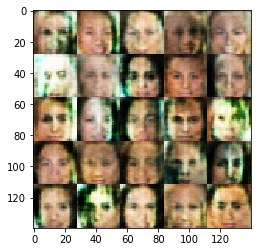

Epoch 1/1... Discriminator Loss: 1.0224... Generator Loss: 0.9266
Epoch 1/1... Discriminator Loss: 1.0422... Generator Loss: 1.9267
Epoch 1/1... Discriminator Loss: 1.3960... Generator Loss: 2.3556
Epoch 1/1... Discriminator Loss: 1.0112... Generator Loss: 0.8757
Epoch 1/1... Discriminator Loss: 1.0586... Generator Loss: 1.6339
Epoch 1/1... Discriminator Loss: 1.0169... Generator Loss: 1.8882
Epoch 1/1... Discriminator Loss: 0.9793... Generator Loss: 1.4939
Epoch 1/1... Discriminator Loss: 0.8867... Generator Loss: 1.2492
Epoch 1/1... Discriminator Loss: 1.0678... Generator Loss: 0.9468
Epoch 1/1... Discriminator Loss: 1.4758... Generator Loss: 0.4808


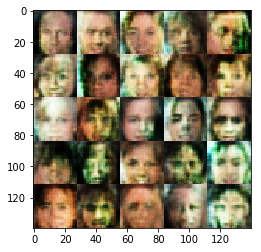

Epoch 1/1... Discriminator Loss: 0.8887... Generator Loss: 0.9965
Epoch 1/1... Discriminator Loss: 0.9732... Generator Loss: 1.5721
Epoch 1/1... Discriminator Loss: 0.8995... Generator Loss: 1.0227
Epoch 1/1... Discriminator Loss: 0.9205... Generator Loss: 1.9045
Epoch 1/1... Discriminator Loss: 1.0681... Generator Loss: 0.8707
Epoch 1/1... Discriminator Loss: 0.9677... Generator Loss: 0.9709
Epoch 1/1... Discriminator Loss: 0.9516... Generator Loss: 1.2918
Epoch 1/1... Discriminator Loss: 0.9599... Generator Loss: 1.1024
Epoch 1/1... Discriminator Loss: 1.1613... Generator Loss: 0.6855
Epoch 1/1... Discriminator Loss: 0.9882... Generator Loss: 1.1695


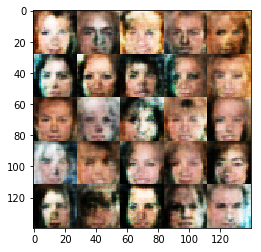

Epoch 1/1... Discriminator Loss: 0.9224... Generator Loss: 1.0636
Epoch 1/1... Discriminator Loss: 1.5211... Generator Loss: 0.4336
Epoch 1/1... Discriminator Loss: 0.9570... Generator Loss: 0.9168
Epoch 1/1... Discriminator Loss: 1.5758... Generator Loss: 0.4066
Epoch 1/1... Discriminator Loss: 0.9220... Generator Loss: 1.2648
Epoch 1/1... Discriminator Loss: 0.9569... Generator Loss: 1.3524
Epoch 1/1... Discriminator Loss: 1.0557... Generator Loss: 0.8732
Epoch 1/1... Discriminator Loss: 0.9688... Generator Loss: 1.2793
Epoch 1/1... Discriminator Loss: 0.9758... Generator Loss: 1.2224
Epoch 1/1... Discriminator Loss: 1.1425... Generator Loss: 0.6831


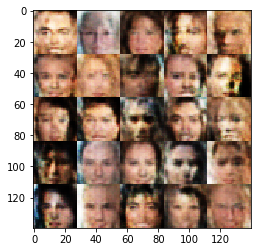

Epoch 1/1... Discriminator Loss: 0.9033... Generator Loss: 1.0407
Epoch 1/1... Discriminator Loss: 0.8560... Generator Loss: 1.3691
Epoch 1/1... Discriminator Loss: 0.7990... Generator Loss: 1.5631
Epoch 1/1... Discriminator Loss: 1.0366... Generator Loss: 1.0091
Epoch 1/1... Discriminator Loss: 1.0870... Generator Loss: 1.3275
Epoch 1/1... Discriminator Loss: 0.8021... Generator Loss: 1.6379
Epoch 1/1... Discriminator Loss: 1.0280... Generator Loss: 1.3787
Epoch 1/1... Discriminator Loss: 0.9577... Generator Loss: 1.8611
Epoch 1/1... Discriminator Loss: 0.9862... Generator Loss: 1.0781
Epoch 1/1... Discriminator Loss: 0.8753... Generator Loss: 1.1196


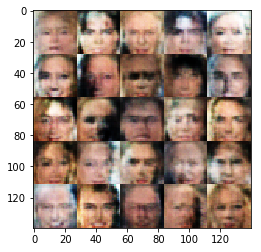

Epoch 1/1... Discriminator Loss: 1.2260... Generator Loss: 0.6806
Epoch 1/1... Discriminator Loss: 0.9170... Generator Loss: 1.4325
Epoch 1/1... Discriminator Loss: 1.4777... Generator Loss: 0.4589
Epoch 1/1... Discriminator Loss: 0.8922... Generator Loss: 1.3652
Epoch 1/1... Discriminator Loss: 1.0683... Generator Loss: 0.8116
Epoch 1/1... Discriminator Loss: 0.8288... Generator Loss: 1.6233
Epoch 1/1... Discriminator Loss: 0.9971... Generator Loss: 1.2394
Epoch 1/1... Discriminator Loss: 1.1911... Generator Loss: 0.7122
Epoch 1/1... Discriminator Loss: 1.1789... Generator Loss: 0.6874
Epoch 1/1... Discriminator Loss: 0.9910... Generator Loss: 1.1046


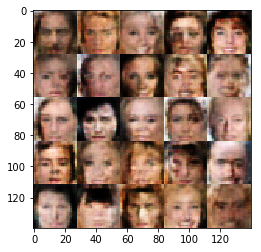

Epoch 1/1... Discriminator Loss: 1.3633... Generator Loss: 0.5364
Epoch 1/1... Discriminator Loss: 0.8559... Generator Loss: 1.1505
Epoch 1/1... Discriminator Loss: 1.1326... Generator Loss: 0.7042
Epoch 1/1... Discriminator Loss: 0.7871... Generator Loss: 1.4356
Epoch 1/1... Discriminator Loss: 0.9800... Generator Loss: 1.0048
Epoch 1/1... Discriminator Loss: 1.0735... Generator Loss: 0.7707
Epoch 1/1... Discriminator Loss: 1.7778... Generator Loss: 0.3196
Epoch 1/1... Discriminator Loss: 1.5182... Generator Loss: 0.4468
Epoch 1/1... Discriminator Loss: 1.3020... Generator Loss: 0.6756
Epoch 1/1... Discriminator Loss: 1.1838... Generator Loss: 0.7063


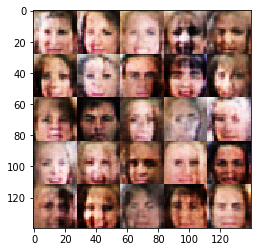

Epoch 1/1... Discriminator Loss: 0.9777... Generator Loss: 1.1448
Epoch 1/1... Discriminator Loss: 1.1065... Generator Loss: 0.7703
Epoch 1/1... Discriminator Loss: 0.8530... Generator Loss: 1.0736
Epoch 1/1... Discriminator Loss: 0.9187... Generator Loss: 1.2216
Epoch 1/1... Discriminator Loss: 0.9212... Generator Loss: 1.5112
Epoch 1/1... Discriminator Loss: 0.9085... Generator Loss: 1.1642
Epoch 1/1... Discriminator Loss: 0.7914... Generator Loss: 1.1879
Epoch 1/1... Discriminator Loss: 1.0261... Generator Loss: 0.9942
Epoch 1/1... Discriminator Loss: 1.1343... Generator Loss: 0.9230
Epoch 1/1... Discriminator Loss: 0.9636... Generator Loss: 1.3497


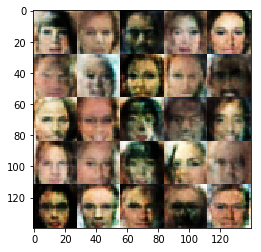

Epoch 1/1... Discriminator Loss: 0.9258... Generator Loss: 1.2085
Epoch 1/1... Discriminator Loss: 0.8994... Generator Loss: 1.1521
Epoch 1/1... Discriminator Loss: 0.8265... Generator Loss: 1.3964
Epoch 1/1... Discriminator Loss: 0.9105... Generator Loss: 1.0019
Epoch 1/1... Discriminator Loss: 1.0966... Generator Loss: 0.8088
Epoch 1/1... Discriminator Loss: 0.9384... Generator Loss: 1.2671
Epoch 1/1... Discriminator Loss: 0.9504... Generator Loss: 1.2144
Epoch 1/1... Discriminator Loss: 0.9006... Generator Loss: 1.1546
Epoch 1/1... Discriminator Loss: 1.0161... Generator Loss: 0.8786
Epoch 1/1... Discriminator Loss: 0.9434... Generator Loss: 1.0130


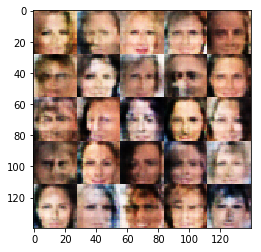

Epoch 1/1... Discriminator Loss: 0.8743... Generator Loss: 1.3291
Epoch 1/1... Discriminator Loss: 0.9461... Generator Loss: 1.0184
Epoch 1/1... Discriminator Loss: 0.9724... Generator Loss: 0.9585
Epoch 1/1... Discriminator Loss: 0.8518... Generator Loss: 1.3328
Epoch 1/1... Discriminator Loss: 0.7951... Generator Loss: 1.6305
Epoch 1/1... Discriminator Loss: 1.1652... Generator Loss: 1.0522
Epoch 1/1... Discriminator Loss: 0.8707... Generator Loss: 1.2947
Epoch 1/1... Discriminator Loss: 0.8719... Generator Loss: 1.5201
Epoch 1/1... Discriminator Loss: 1.1011... Generator Loss: 0.7412
Epoch 1/1... Discriminator Loss: 0.7299... Generator Loss: 1.5707


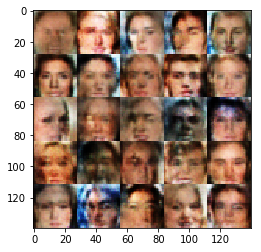

Epoch 1/1... Discriminator Loss: 0.9096... Generator Loss: 1.3313
Epoch 1/1... Discriminator Loss: 0.8645... Generator Loss: 1.2372
Epoch 1/1... Discriminator Loss: 1.1947... Generator Loss: 0.6452
Epoch 1/1... Discriminator Loss: 0.8293... Generator Loss: 2.5663
Epoch 1/1... Discriminator Loss: 1.1251... Generator Loss: 1.1567
Epoch 1/1... Discriminator Loss: 1.1991... Generator Loss: 0.7065
Epoch 1/1... Discriminator Loss: 0.9498... Generator Loss: 1.3102
Epoch 1/1... Discriminator Loss: 0.9241... Generator Loss: 0.9772
Epoch 1/1... Discriminator Loss: 0.9119... Generator Loss: 1.1198
Epoch 1/1... Discriminator Loss: 1.2557... Generator Loss: 0.6229


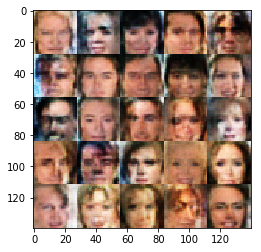

Epoch 1/1... Discriminator Loss: 0.8326... Generator Loss: 1.9319
Epoch 1/1... Discriminator Loss: 0.8745... Generator Loss: 1.2470
Epoch 1/1... Discriminator Loss: 0.9097... Generator Loss: 1.0064
Epoch 1/1... Discriminator Loss: 0.8824... Generator Loss: 1.3800
Epoch 1/1... Discriminator Loss: 1.1675... Generator Loss: 0.7046
Epoch 1/1... Discriminator Loss: 1.0523... Generator Loss: 1.0361
Epoch 1/1... Discriminator Loss: 0.9740... Generator Loss: 1.0694
Epoch 1/1... Discriminator Loss: 1.1849... Generator Loss: 0.7414
Epoch 1/1... Discriminator Loss: 1.1464... Generator Loss: 1.8645
Epoch 1/1... Discriminator Loss: 1.1750... Generator Loss: 0.6873


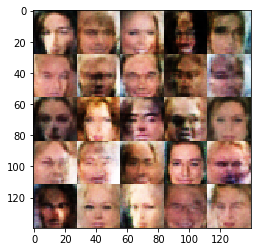

Epoch 1/1... Discriminator Loss: 1.0872... Generator Loss: 0.8246
Epoch 1/1... Discriminator Loss: 1.1275... Generator Loss: 1.5169
Epoch 1/1... Discriminator Loss: 0.8317... Generator Loss: 1.2387
Epoch 1/1... Discriminator Loss: 0.8833... Generator Loss: 1.2257
Epoch 1/1... Discriminator Loss: 1.2275... Generator Loss: 0.6674
Epoch 1/1... Discriminator Loss: 0.9752... Generator Loss: 0.9789
Epoch 1/1... Discriminator Loss: 0.9144... Generator Loss: 1.1398
Epoch 1/1... Discriminator Loss: 0.9214... Generator Loss: 1.2094
Epoch 1/1... Discriminator Loss: 0.8742... Generator Loss: 1.1850
Epoch 1/1... Discriminator Loss: 0.8211... Generator Loss: 1.2844


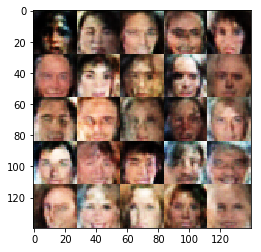

Epoch 1/1... Discriminator Loss: 1.0288... Generator Loss: 1.9428
Epoch 1/1... Discriminator Loss: 1.0358... Generator Loss: 1.0110
Epoch 1/1... Discriminator Loss: 1.4213... Generator Loss: 0.5076
Epoch 1/1... Discriminator Loss: 0.9398... Generator Loss: 1.0649
Epoch 1/1... Discriminator Loss: 0.9227... Generator Loss: 1.3837
Epoch 1/1... Discriminator Loss: 1.3223... Generator Loss: 0.5619
Epoch 1/1... Discriminator Loss: 1.1393... Generator Loss: 0.8880
Epoch 1/1... Discriminator Loss: 1.0415... Generator Loss: 0.8135
Epoch 1/1... Discriminator Loss: 1.2160... Generator Loss: 0.6421
Epoch 1/1... Discriminator Loss: 0.9428... Generator Loss: 1.0564


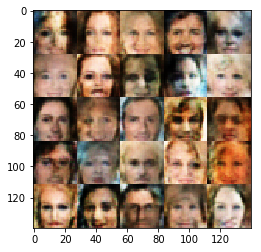

Epoch 1/1... Discriminator Loss: 1.0113... Generator Loss: 0.9692
Epoch 1/1... Discriminator Loss: 0.8700... Generator Loss: 1.3087
Epoch 1/1... Discriminator Loss: 1.3300... Generator Loss: 0.5445
Epoch 1/1... Discriminator Loss: 1.5031... Generator Loss: 0.4678
Epoch 1/1... Discriminator Loss: 1.0753... Generator Loss: 2.4447
Epoch 1/1... Discriminator Loss: 1.3971... Generator Loss: 0.5003
Epoch 1/1... Discriminator Loss: 1.1799... Generator Loss: 0.7001
Epoch 1/1... Discriminator Loss: 1.0995... Generator Loss: 0.7481
Epoch 1/1... Discriminator Loss: 1.0041... Generator Loss: 0.9544
Epoch 1/1... Discriminator Loss: 0.9686... Generator Loss: 1.6882


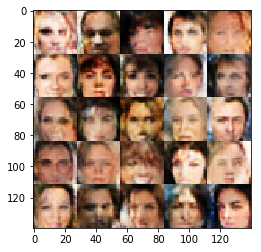

Epoch 1/1... Discriminator Loss: 0.9472... Generator Loss: 1.2009
Epoch 1/1... Discriminator Loss: 0.9487... Generator Loss: 1.2197
Epoch 1/1... Discriminator Loss: 0.6809... Generator Loss: 1.8576
Epoch 1/1... Discriminator Loss: 1.1977... Generator Loss: 1.1297
Epoch 1/1... Discriminator Loss: 1.1851... Generator Loss: 0.6670
Epoch 1/1... Discriminator Loss: 1.0273... Generator Loss: 1.4119
Epoch 1/1... Discriminator Loss: 1.0054... Generator Loss: 0.9386
Epoch 1/1... Discriminator Loss: 0.9009... Generator Loss: 1.2732
Epoch 1/1... Discriminator Loss: 1.1766... Generator Loss: 0.7309
Epoch 1/1... Discriminator Loss: 1.0640... Generator Loss: 0.7661


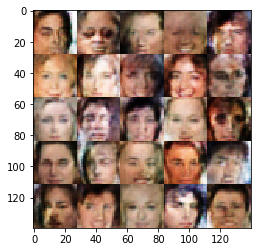

Epoch 1/1... Discriminator Loss: 0.8726... Generator Loss: 1.0927
Epoch 1/1... Discriminator Loss: 0.8227... Generator Loss: 1.2718
Epoch 1/1... Discriminator Loss: 0.8739... Generator Loss: 2.4248
Epoch 1/1... Discriminator Loss: 0.8716... Generator Loss: 1.3627
Epoch 1/1... Discriminator Loss: 1.1542... Generator Loss: 0.6564
Epoch 1/1... Discriminator Loss: 0.7667... Generator Loss: 1.3831
Epoch 1/1... Discriminator Loss: 1.0821... Generator Loss: 0.8359
Epoch 1/1... Discriminator Loss: 1.0586... Generator Loss: 0.7730
Epoch 1/1... Discriminator Loss: 0.9871... Generator Loss: 0.9176
Epoch 1/1... Discriminator Loss: 0.8691... Generator Loss: 1.3905


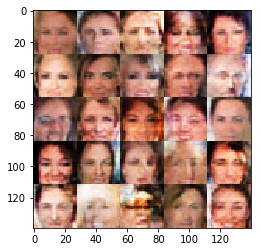

Epoch 1/1... Discriminator Loss: 0.7622... Generator Loss: 1.4357
Epoch 1/1... Discriminator Loss: 0.9289... Generator Loss: 1.0144
Epoch 1/1... Discriminator Loss: 1.0901... Generator Loss: 0.7495
Epoch 1/1... Discriminator Loss: 0.9801... Generator Loss: 0.9739
Epoch 1/1... Discriminator Loss: 0.8735... Generator Loss: 1.2350
Epoch 1/1... Discriminator Loss: 0.9181... Generator Loss: 1.1039
Epoch 1/1... Discriminator Loss: 1.1063... Generator Loss: 0.8253
Epoch 1/1... Discriminator Loss: 1.2652... Generator Loss: 0.5738
Epoch 1/1... Discriminator Loss: 0.9162... Generator Loss: 1.0404
Epoch 1/1... Discriminator Loss: 0.9731... Generator Loss: 0.9990


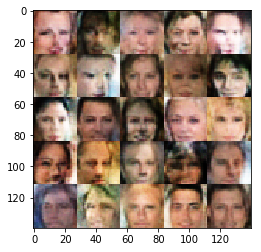

Epoch 1/1... Discriminator Loss: 0.8144... Generator Loss: 1.8066
Epoch 1/1... Discriminator Loss: 1.0426... Generator Loss: 0.8846
Epoch 1/1... Discriminator Loss: 0.9056... Generator Loss: 1.3627
Epoch 1/1... Discriminator Loss: 1.0623... Generator Loss: 0.9113
Epoch 1/1... Discriminator Loss: 0.9837... Generator Loss: 0.9875
Epoch 1/1... Discriminator Loss: 1.0801... Generator Loss: 0.7553
Epoch 1/1... Discriminator Loss: 0.8847... Generator Loss: 2.3549
Epoch 1/1... Discriminator Loss: 1.2465... Generator Loss: 0.6198
Epoch 1/1... Discriminator Loss: 1.7851... Generator Loss: 1.7067
Epoch 1/1... Discriminator Loss: 1.0824... Generator Loss: 0.8300


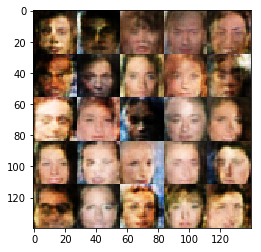

Epoch 1/1... Discriminator Loss: 1.1156... Generator Loss: 0.7330
Epoch 1/1... Discriminator Loss: 0.8596... Generator Loss: 1.1122
Epoch 1/1... Discriminator Loss: 0.9144... Generator Loss: 1.0661
Epoch 1/1... Discriminator Loss: 0.9270... Generator Loss: 1.3311
Epoch 1/1... Discriminator Loss: 0.9252... Generator Loss: 1.1807
Epoch 1/1... Discriminator Loss: 1.0894... Generator Loss: 0.8252
Epoch 1/1... Discriminator Loss: 0.9048... Generator Loss: 1.3459
Epoch 1/1... Discriminator Loss: 0.8722... Generator Loss: 1.1005
Epoch 1/1... Discriminator Loss: 0.8235... Generator Loss: 1.3265
Epoch 1/1... Discriminator Loss: 0.9824... Generator Loss: 1.2254


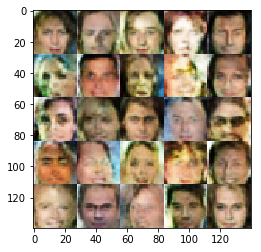

Epoch 1/1... Discriminator Loss: 1.0558... Generator Loss: 0.8139
Epoch 1/1... Discriminator Loss: 1.1324... Generator Loss: 0.6787
Epoch 1/1... Discriminator Loss: 0.8804... Generator Loss: 1.1198
Epoch 1/1... Discriminator Loss: 0.8806... Generator Loss: 2.4105
Epoch 1/1... Discriminator Loss: 0.9674... Generator Loss: 0.8832
Epoch 1/1... Discriminator Loss: 0.8958... Generator Loss: 1.0696
Epoch 1/1... Discriminator Loss: 1.2246... Generator Loss: 0.6708
Epoch 1/1... Discriminator Loss: 0.8634... Generator Loss: 1.1226
Epoch 1/1... Discriminator Loss: 1.5741... Generator Loss: 0.3925
Epoch 1/1... Discriminator Loss: 1.1753... Generator Loss: 1.6356


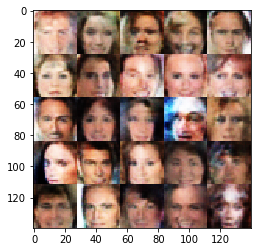

Epoch 1/1... Discriminator Loss: 1.3180... Generator Loss: 0.5954
Epoch 1/1... Discriminator Loss: 1.4729... Generator Loss: 0.4749
Epoch 1/1... Discriminator Loss: 1.0423... Generator Loss: 1.4575
Epoch 1/1... Discriminator Loss: 1.0125... Generator Loss: 0.8639
Epoch 1/1... Discriminator Loss: 1.1100... Generator Loss: 0.7918
Epoch 1/1... Discriminator Loss: 0.9890... Generator Loss: 0.9306
Epoch 1/1... Discriminator Loss: 0.9021... Generator Loss: 1.2089
Epoch 1/1... Discriminator Loss: 0.8781... Generator Loss: 1.3252
Epoch 1/1... Discriminator Loss: 1.4831... Generator Loss: 0.4330
Epoch 1/1... Discriminator Loss: 2.2817... Generator Loss: 0.2044


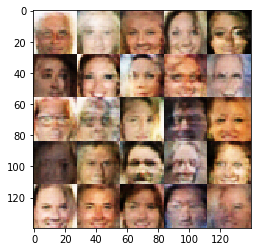

Epoch 1/1... Discriminator Loss: 0.9503... Generator Loss: 1.8926
Epoch 1/1... Discriminator Loss: 0.8698... Generator Loss: 1.1199
Epoch 1/1... Discriminator Loss: 0.9393... Generator Loss: 1.2089
Epoch 1/1... Discriminator Loss: 0.8253... Generator Loss: 1.2373
Epoch 1/1... Discriminator Loss: 0.9196... Generator Loss: 1.1226
Epoch 1/1... Discriminator Loss: 1.3141... Generator Loss: 0.5625
Epoch 1/1... Discriminator Loss: 1.1189... Generator Loss: 0.7285
Epoch 1/1... Discriminator Loss: 1.0114... Generator Loss: 1.2302
Epoch 1/1... Discriminator Loss: 1.3180... Generator Loss: 0.6033
Epoch 1/1... Discriminator Loss: 1.0399... Generator Loss: 0.8352


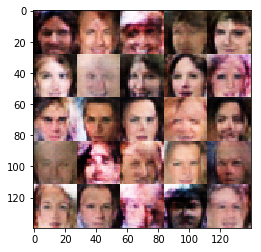

Epoch 1/1... Discriminator Loss: 1.1044... Generator Loss: 1.0145
Epoch 1/1... Discriminator Loss: 1.0859... Generator Loss: 0.8713
Epoch 1/1... Discriminator Loss: 1.4992... Generator Loss: 0.4337
Epoch 1/1... Discriminator Loss: 0.7721... Generator Loss: 1.3350
Epoch 1/1... Discriminator Loss: 0.9998... Generator Loss: 1.0310
Epoch 1/1... Discriminator Loss: 0.9934... Generator Loss: 1.0720
Epoch 1/1... Discriminator Loss: 1.6235... Generator Loss: 0.3907
Epoch 1/1... Discriminator Loss: 0.8197... Generator Loss: 1.9078
Epoch 1/1... Discriminator Loss: 1.0982... Generator Loss: 0.7951
Epoch 1/1... Discriminator Loss: 1.0155... Generator Loss: 1.2132


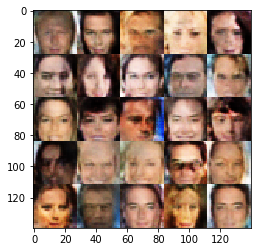

Epoch 1/1... Discriminator Loss: 0.9157... Generator Loss: 1.1608
Epoch 1/1... Discriminator Loss: 0.7995... Generator Loss: 1.3249
Epoch 1/1... Discriminator Loss: 0.8639... Generator Loss: 1.1941
Epoch 1/1... Discriminator Loss: 0.9265... Generator Loss: 1.3899
Epoch 1/1... Discriminator Loss: 1.1070... Generator Loss: 0.7591
Epoch 1/1... Discriminator Loss: 1.3148... Generator Loss: 0.5699
Epoch 1/1... Discriminator Loss: 0.8652... Generator Loss: 1.0888
Epoch 1/1... Discriminator Loss: 0.9250... Generator Loss: 1.0407
Epoch 1/1... Discriminator Loss: 0.8481... Generator Loss: 1.1955
Epoch 1/1... Discriminator Loss: 0.9386... Generator Loss: 1.1591


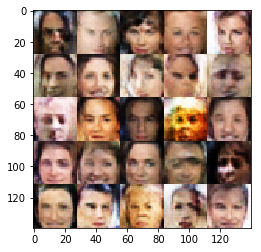

Epoch 1/1... Discriminator Loss: 0.8818... Generator Loss: 1.0856
Epoch 1/1... Discriminator Loss: 1.0331... Generator Loss: 0.8280
Epoch 1/1... Discriminator Loss: 1.2197... Generator Loss: 0.6703
Epoch 1/1... Discriminator Loss: 1.1849... Generator Loss: 0.6762
Epoch 1/1... Discriminator Loss: 1.0645... Generator Loss: 1.0173
Epoch 1/1... Discriminator Loss: 1.2130... Generator Loss: 0.6462
Epoch 1/1... Discriminator Loss: 1.0308... Generator Loss: 0.8567
Epoch 1/1... Discriminator Loss: 0.9902... Generator Loss: 1.9582
Epoch 1/1... Discriminator Loss: 0.9826... Generator Loss: 0.9432
Epoch 1/1... Discriminator Loss: 1.0986... Generator Loss: 0.7861


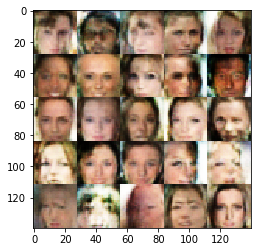

Epoch 1/1... Discriminator Loss: 1.1683... Generator Loss: 0.6631
Epoch 1/1... Discriminator Loss: 0.9611... Generator Loss: 0.9232
Epoch 1/1... Discriminator Loss: 1.1425... Generator Loss: 0.7122
Epoch 1/1... Discriminator Loss: 1.2336... Generator Loss: 0.5934
Epoch 1/1... Discriminator Loss: 0.8750... Generator Loss: 1.2374
Epoch 1/1... Discriminator Loss: 0.8988... Generator Loss: 1.4151
Epoch 1/1... Discriminator Loss: 1.0316... Generator Loss: 0.9537
Epoch 1/1... Discriminator Loss: 0.9319... Generator Loss: 1.0814
Epoch 1/1... Discriminator Loss: 1.4326... Generator Loss: 0.4680
Epoch 1/1... Discriminator Loss: 0.9456... Generator Loss: 1.0389


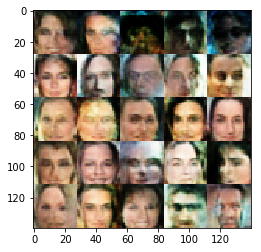

Epoch 1/1... Discriminator Loss: 1.2648... Generator Loss: 0.5727
Epoch 1/1... Discriminator Loss: 0.9125... Generator Loss: 1.4688
Epoch 1/1... Discriminator Loss: 0.9260... Generator Loss: 1.4904
Epoch 1/1... Discriminator Loss: 1.1211... Generator Loss: 0.7626
Epoch 1/1... Discriminator Loss: 1.0566... Generator Loss: 0.8028
Epoch 1/1... Discriminator Loss: 1.1391... Generator Loss: 0.8143
Epoch 1/1... Discriminator Loss: 1.0880... Generator Loss: 0.8265
Epoch 1/1... Discriminator Loss: 0.9432... Generator Loss: 1.0931
Epoch 1/1... Discriminator Loss: 1.2405... Generator Loss: 0.6274
Epoch 1/1... Discriminator Loss: 0.8103... Generator Loss: 1.4623


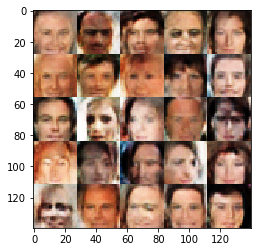

Epoch 1/1... Discriminator Loss: 1.0728... Generator Loss: 1.4246
Epoch 1/1... Discriminator Loss: 1.0920... Generator Loss: 0.7674
Epoch 1/1... Discriminator Loss: 0.8757... Generator Loss: 1.0985
Epoch 1/1... Discriminator Loss: 0.8231... Generator Loss: 1.7047
Epoch 1/1... Discriminator Loss: 0.8187... Generator Loss: 1.1601
Epoch 1/1... Discriminator Loss: 1.0911... Generator Loss: 0.8351
Epoch 1/1... Discriminator Loss: 0.9464... Generator Loss: 0.9963
Epoch 1/1... Discriminator Loss: 1.1722... Generator Loss: 0.7152
Epoch 1/1... Discriminator Loss: 0.7317... Generator Loss: 1.4612
Epoch 1/1... Discriminator Loss: 0.9440... Generator Loss: 1.9666


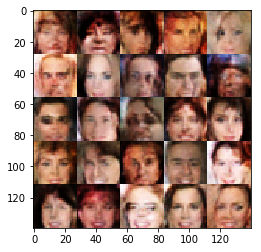

Epoch 1/1... Discriminator Loss: 1.4330... Generator Loss: 0.4752
Epoch 1/1... Discriminator Loss: 1.1037... Generator Loss: 0.9871
Epoch 1/1... Discriminator Loss: 1.0035... Generator Loss: 0.9259
Epoch 1/1... Discriminator Loss: 1.0195... Generator Loss: 1.0523
Epoch 1/1... Discriminator Loss: 0.9022... Generator Loss: 1.0376
Epoch 1/1... Discriminator Loss: 0.7102... Generator Loss: 1.4546
Epoch 1/1... Discriminator Loss: 0.9778... Generator Loss: 1.0577
Epoch 1/1... Discriminator Loss: 1.0085... Generator Loss: 1.1088
Epoch 1/1... Discriminator Loss: 1.3533... Generator Loss: 0.5816
Epoch 1/1... Discriminator Loss: 0.8929... Generator Loss: 1.2823


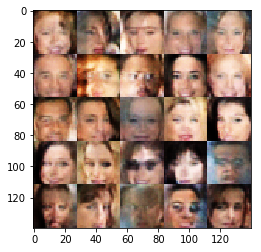

Epoch 1/1... Discriminator Loss: 0.9659... Generator Loss: 1.1604
Epoch 1/1... Discriminator Loss: 1.1307... Generator Loss: 0.8067
Epoch 1/1... Discriminator Loss: 1.3801... Generator Loss: 0.4970
Epoch 1/1... Discriminator Loss: 1.2190... Generator Loss: 0.6571
Epoch 1/1... Discriminator Loss: 1.1461... Generator Loss: 0.7004
Epoch 1/1... Discriminator Loss: 1.1372... Generator Loss: 0.7152
Epoch 1/1... Discriminator Loss: 1.1522... Generator Loss: 0.6804
Epoch 1/1... Discriminator Loss: 0.8461... Generator Loss: 1.4614
Epoch 1/1... Discriminator Loss: 0.7563... Generator Loss: 1.5205
Epoch 1/1... Discriminator Loss: 1.1145... Generator Loss: 0.7788


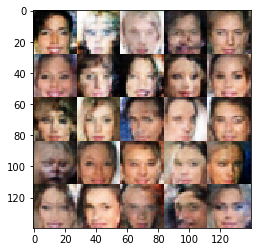

Epoch 1/1... Discriminator Loss: 0.8811... Generator Loss: 1.1309
Epoch 1/1... Discriminator Loss: 1.1501... Generator Loss: 1.3180
Epoch 1/1... Discriminator Loss: 1.0663... Generator Loss: 0.8183
Epoch 1/1... Discriminator Loss: 1.2419... Generator Loss: 0.6942
Epoch 1/1... Discriminator Loss: 0.8906... Generator Loss: 1.1449
Epoch 1/1... Discriminator Loss: 0.9073... Generator Loss: 1.2060
Epoch 1/1... Discriminator Loss: 1.1757... Generator Loss: 0.6475
Epoch 1/1... Discriminator Loss: 0.9571... Generator Loss: 1.0606
Epoch 1/1... Discriminator Loss: 0.9757... Generator Loss: 1.7558
Epoch 1/1... Discriminator Loss: 1.0553... Generator Loss: 0.8120


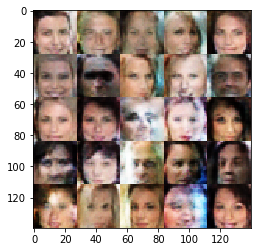

Epoch 1/1... Discriminator Loss: 1.0771... Generator Loss: 0.9493
Epoch 1/1... Discriminator Loss: 0.9238... Generator Loss: 1.3220
Epoch 1/1... Discriminator Loss: 1.0260... Generator Loss: 0.8886
Epoch 1/1... Discriminator Loss: 0.9724... Generator Loss: 1.0976
Epoch 1/1... Discriminator Loss: 0.8100... Generator Loss: 1.1810
Epoch 1/1... Discriminator Loss: 0.9954... Generator Loss: 1.0815
Epoch 1/1... Discriminator Loss: 0.8709... Generator Loss: 1.1789
Epoch 1/1... Discriminator Loss: 0.9896... Generator Loss: 1.0290
Epoch 1/1... Discriminator Loss: 1.1538... Generator Loss: 0.8399
Epoch 1/1... Discriminator Loss: 1.1456... Generator Loss: 0.7926


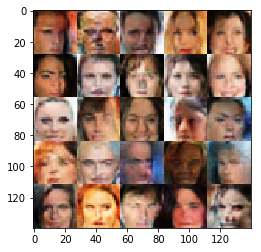

Epoch 1/1... Discriminator Loss: 0.8009... Generator Loss: 1.4042
Epoch 1/1... Discriminator Loss: 1.4231... Generator Loss: 0.5006
Epoch 1/1... Discriminator Loss: 1.0246... Generator Loss: 1.0882
Epoch 1/1... Discriminator Loss: 1.4502... Generator Loss: 0.4615
Epoch 1/1... Discriminator Loss: 0.9089... Generator Loss: 1.0814
Epoch 1/1... Discriminator Loss: 1.3434... Generator Loss: 0.5614
Epoch 1/1... Discriminator Loss: 1.2430... Generator Loss: 0.6482
Epoch 1/1... Discriminator Loss: 1.0111... Generator Loss: 0.9119
Epoch 1/1... Discriminator Loss: 1.4612... Generator Loss: 0.4473
Epoch 1/1... Discriminator Loss: 1.0953... Generator Loss: 0.7656


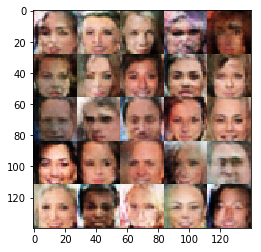

Epoch 1/1... Discriminator Loss: 1.1569... Generator Loss: 0.7434
Epoch 1/1... Discriminator Loss: 0.8531... Generator Loss: 1.1555
Epoch 1/1... Discriminator Loss: 1.1069... Generator Loss: 0.7657
Epoch 1/1... Discriminator Loss: 0.7791... Generator Loss: 1.3358
Epoch 1/1... Discriminator Loss: 1.2740... Generator Loss: 0.5764
Epoch 1/1... Discriminator Loss: 1.3726... Generator Loss: 0.5272
Epoch 1/1... Discriminator Loss: 0.9138... Generator Loss: 1.0250
Epoch 1/1... Discriminator Loss: 1.2064... Generator Loss: 0.6398
Epoch 1/1... Discriminator Loss: 1.6732... Generator Loss: 0.3465
Epoch 1/1... Discriminator Loss: 1.0258... Generator Loss: 0.9699


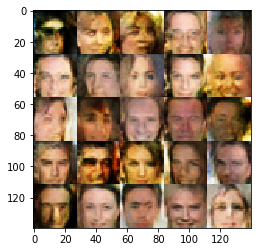

Epoch 1/1... Discriminator Loss: 1.0233... Generator Loss: 0.8603
Epoch 1/1... Discriminator Loss: 1.1930... Generator Loss: 0.7714
Epoch 1/1... Discriminator Loss: 0.9419... Generator Loss: 1.2838
Epoch 1/1... Discriminator Loss: 0.7816... Generator Loss: 1.3435
Epoch 1/1... Discriminator Loss: 1.1992... Generator Loss: 0.6946
Epoch 1/1... Discriminator Loss: 1.1380... Generator Loss: 1.1927
Epoch 1/1... Discriminator Loss: 0.8853... Generator Loss: 1.0735
Epoch 1/1... Discriminator Loss: 1.1929... Generator Loss: 0.6321
Epoch 1/1... Discriminator Loss: 0.7630... Generator Loss: 1.6138
Epoch 1/1... Discriminator Loss: 0.5611... Generator Loss: 2.1799


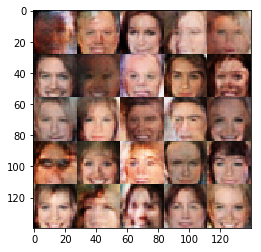

Epoch 1/1... Discriminator Loss: 1.0433... Generator Loss: 1.1208
Epoch 1/1... Discriminator Loss: 0.9872... Generator Loss: 1.4419
Epoch 1/1... Discriminator Loss: 0.8483... Generator Loss: 1.1373
Epoch 1/1... Discriminator Loss: 1.0987... Generator Loss: 0.7343
Epoch 1/1... Discriminator Loss: 0.9426... Generator Loss: 1.0398
Epoch 1/1... Discriminator Loss: 1.2142... Generator Loss: 0.6707
Epoch 1/1... Discriminator Loss: 0.7421... Generator Loss: 1.3408
Epoch 1/1... Discriminator Loss: 1.0251... Generator Loss: 0.9792
Epoch 1/1... Discriminator Loss: 1.4650... Generator Loss: 0.4598
Epoch 1/1... Discriminator Loss: 0.9823... Generator Loss: 1.0469


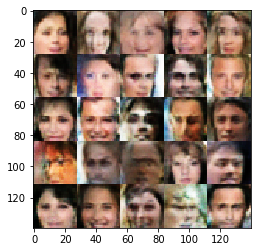

Epoch 1/1... Discriminator Loss: 1.3983... Generator Loss: 0.5240
Epoch 1/1... Discriminator Loss: 1.2287... Generator Loss: 0.7100
Epoch 1/1... Discriminator Loss: 0.8925... Generator Loss: 1.0341
Epoch 1/1... Discriminator Loss: 1.0285... Generator Loss: 0.8716
Epoch 1/1... Discriminator Loss: 1.3780... Generator Loss: 0.5035
Epoch 1/1... Discriminator Loss: 0.9483... Generator Loss: 1.2304
Epoch 1/1... Discriminator Loss: 0.9700... Generator Loss: 1.1429
Epoch 1/1... Discriminator Loss: 0.8970... Generator Loss: 1.0093
Epoch 1/1... Discriminator Loss: 1.1758... Generator Loss: 0.6345
Epoch 1/1... Discriminator Loss: 1.2194... Generator Loss: 0.5906


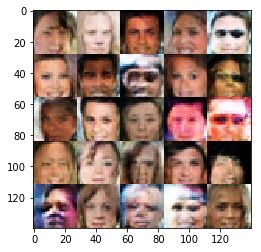

Epoch 1/1... Discriminator Loss: 1.0418... Generator Loss: 0.8833
Epoch 1/1... Discriminator Loss: 1.0311... Generator Loss: 0.9045
Epoch 1/1... Discriminator Loss: 0.9908... Generator Loss: 0.9682
Epoch 1/1... Discriminator Loss: 0.8506... Generator Loss: 1.3648
Epoch 1/1... Discriminator Loss: 1.2093... Generator Loss: 0.6807
Epoch 1/1... Discriminator Loss: 1.6080... Generator Loss: 0.4030
Epoch 1/1... Discriminator Loss: 1.4751... Generator Loss: 0.4820
Epoch 1/1... Discriminator Loss: 0.9521... Generator Loss: 0.9171
Epoch 1/1... Discriminator Loss: 1.0448... Generator Loss: 0.8514
Epoch 1/1... Discriminator Loss: 1.1471... Generator Loss: 0.7539


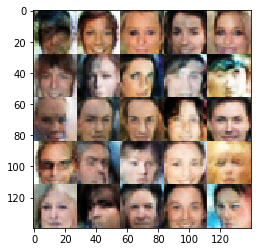

Epoch 1/1... Discriminator Loss: 1.0745... Generator Loss: 0.8103
Epoch 1/1... Discriminator Loss: 1.1895... Generator Loss: 0.6633
Epoch 1/1... Discriminator Loss: 0.9802... Generator Loss: 0.9147
Epoch 1/1... Discriminator Loss: 0.9035... Generator Loss: 1.3684
Epoch 1/1... Discriminator Loss: 0.9657... Generator Loss: 0.9587
Epoch 1/1... Discriminator Loss: 1.4362... Generator Loss: 0.4786
Epoch 1/1... Discriminator Loss: 1.3170... Generator Loss: 0.5401
Epoch 1/1... Discriminator Loss: 1.0740... Generator Loss: 0.8227
Epoch 1/1... Discriminator Loss: 0.9692... Generator Loss: 0.9365
Epoch 1/1... Discriminator Loss: 0.8699... Generator Loss: 1.6216


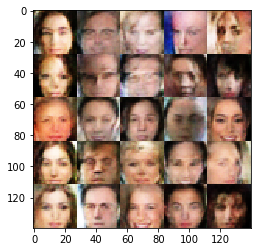

Epoch 1/1... Discriminator Loss: 1.2188... Generator Loss: 0.6679
Epoch 1/1... Discriminator Loss: 1.1548... Generator Loss: 0.7711
Epoch 1/1... Discriminator Loss: 1.2815... Generator Loss: 0.6016
Epoch 1/1... Discriminator Loss: 1.1003... Generator Loss: 2.2726
Epoch 1/1... Discriminator Loss: 0.8645... Generator Loss: 1.2143
Epoch 1/1... Discriminator Loss: 0.9517... Generator Loss: 0.9273
Epoch 1/1... Discriminator Loss: 1.0121... Generator Loss: 1.1784
Epoch 1/1... Discriminator Loss: 0.8658... Generator Loss: 1.3431
Epoch 1/1... Discriminator Loss: 1.0738... Generator Loss: 0.9018
Epoch 1/1... Discriminator Loss: 1.0813... Generator Loss: 0.9803


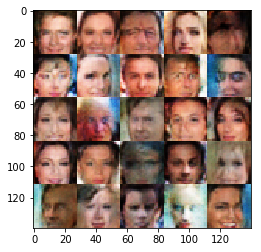

Epoch 1/1... Discriminator Loss: 1.3884... Generator Loss: 0.5319
Epoch 1/1... Discriminator Loss: 1.1193... Generator Loss: 0.7336
Epoch 1/1... Discriminator Loss: 1.0399... Generator Loss: 0.8541
Epoch 1/1... Discriminator Loss: 1.0728... Generator Loss: 0.9015
Epoch 1/1... Discriminator Loss: 1.2767... Generator Loss: 0.5766
Epoch 1/1... Discriminator Loss: 1.0004... Generator Loss: 1.5552
Epoch 1/1... Discriminator Loss: 1.3685... Generator Loss: 0.5472
Epoch 1/1... Discriminator Loss: 0.9732... Generator Loss: 1.0310
Epoch 1/1... Discriminator Loss: 0.8764... Generator Loss: 1.2874
Epoch 1/1... Discriminator Loss: 1.0717... Generator Loss: 1.0447


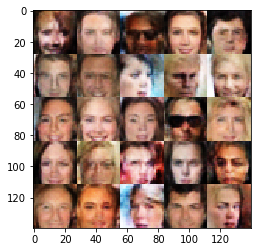

Epoch 1/1... Discriminator Loss: 0.8567... Generator Loss: 1.1347
Epoch 1/1... Discriminator Loss: 1.1313... Generator Loss: 1.5648
Epoch 1/1... Discriminator Loss: 1.5878... Generator Loss: 0.4100
Epoch 1/1... Discriminator Loss: 0.9587... Generator Loss: 1.0698
Epoch 1/1... Discriminator Loss: 1.0752... Generator Loss: 0.8307
Epoch 1/1... Discriminator Loss: 1.0356... Generator Loss: 0.8232
Epoch 1/1... Discriminator Loss: 0.9497... Generator Loss: 1.1010
Epoch 1/1... Discriminator Loss: 1.4675... Generator Loss: 0.4645
Epoch 1/1... Discriminator Loss: 1.2223... Generator Loss: 0.7388
Epoch 1/1... Discriminator Loss: 0.9600... Generator Loss: 1.0592


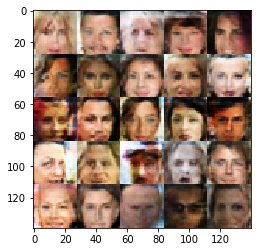

Epoch 1/1... Discriminator Loss: 1.0557... Generator Loss: 0.8949
Epoch 1/1... Discriminator Loss: 0.8372... Generator Loss: 1.5062
Epoch 1/1... Discriminator Loss: 1.2688... Generator Loss: 0.5639
Epoch 1/1... Discriminator Loss: 1.5206... Generator Loss: 0.4301
Epoch 1/1... Discriminator Loss: 1.0880... Generator Loss: 0.8273
Epoch 1/1... Discriminator Loss: 1.3480... Generator Loss: 0.5638
Epoch 1/1... Discriminator Loss: 0.9077... Generator Loss: 1.1542
Epoch 1/1... Discriminator Loss: 1.0393... Generator Loss: 1.0297
Epoch 1/1... Discriminator Loss: 1.0539... Generator Loss: 0.8595
Epoch 1/1... Discriminator Loss: 1.0250... Generator Loss: 0.8336


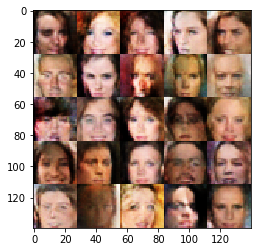

Epoch 1/1... Discriminator Loss: 1.6533... Generator Loss: 0.3604
Epoch 1/1... Discriminator Loss: 0.9173... Generator Loss: 1.3564
Epoch 1/1... Discriminator Loss: 0.9691... Generator Loss: 1.0382
Epoch 1/1... Discriminator Loss: 1.0378... Generator Loss: 0.9286
Epoch 1/1... Discriminator Loss: 1.3401... Generator Loss: 0.5324
Epoch 1/1... Discriminator Loss: 1.6717... Generator Loss: 0.3390
Epoch 1/1... Discriminator Loss: 1.2324... Generator Loss: 0.6656
Epoch 1/1... Discriminator Loss: 1.3284... Generator Loss: 0.5901
Epoch 1/1... Discriminator Loss: 1.2600... Generator Loss: 0.6447
Epoch 1/1... Discriminator Loss: 1.2331... Generator Loss: 0.8464


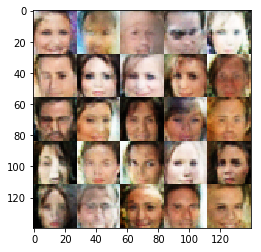

Epoch 1/1... Discriminator Loss: 1.5384... Generator Loss: 0.4377
Epoch 1/1... Discriminator Loss: 1.2299... Generator Loss: 0.6315
Epoch 1/1... Discriminator Loss: 1.7480... Generator Loss: 0.3120
Epoch 1/1... Discriminator Loss: 1.1678... Generator Loss: 0.8750
Epoch 1/1... Discriminator Loss: 1.2499... Generator Loss: 0.5776
Epoch 1/1... Discriminator Loss: 0.9205... Generator Loss: 1.3265
Epoch 1/1... Discriminator Loss: 0.7619... Generator Loss: 1.5191
Epoch 1/1... Discriminator Loss: 1.0739... Generator Loss: 0.7118
Epoch 1/1... Discriminator Loss: 1.0799... Generator Loss: 0.8659
Epoch 1/1... Discriminator Loss: 1.0127... Generator Loss: 0.9223


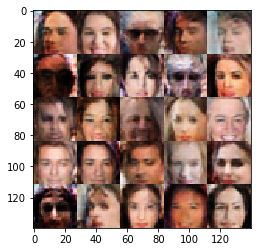

Epoch 1/1... Discriminator Loss: 1.3008... Generator Loss: 0.5647
Epoch 1/1... Discriminator Loss: 1.4178... Generator Loss: 0.4894
Epoch 1/1... Discriminator Loss: 1.0446... Generator Loss: 0.8594
Epoch 1/1... Discriminator Loss: 0.8634... Generator Loss: 1.2060
Epoch 1/1... Discriminator Loss: 1.1070... Generator Loss: 0.7645
Epoch 1/1... Discriminator Loss: 0.8902... Generator Loss: 1.1109
Epoch 1/1... Discriminator Loss: 0.8460... Generator Loss: 1.2804
Epoch 1/1... Discriminator Loss: 1.0092... Generator Loss: 1.0093
Epoch 1/1... Discriminator Loss: 1.2797... Generator Loss: 0.5706
Epoch 1/1... Discriminator Loss: 0.8372... Generator Loss: 1.1548


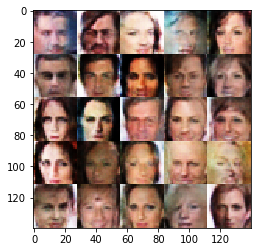

Epoch 1/1... Discriminator Loss: 1.0905... Generator Loss: 0.8090
Epoch 1/1... Discriminator Loss: 0.7531... Generator Loss: 1.4715
Epoch 1/1... Discriminator Loss: 1.3041... Generator Loss: 0.6426
Epoch 1/1... Discriminator Loss: 1.1586... Generator Loss: 0.7088
Epoch 1/1... Discriminator Loss: 1.2613... Generator Loss: 0.6318
Epoch 1/1... Discriminator Loss: 1.1974... Generator Loss: 0.6197
Epoch 1/1... Discriminator Loss: 0.9987... Generator Loss: 0.8871
Epoch 1/1... Discriminator Loss: 1.1033... Generator Loss: 0.8368
Epoch 1/1... Discriminator Loss: 1.1285... Generator Loss: 0.7519
Epoch 1/1... Discriminator Loss: 1.0174... Generator Loss: 1.1624


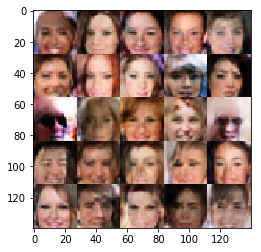

Epoch 1/1... Discriminator Loss: 0.8161... Generator Loss: 1.5134
Epoch 1/1... Discriminator Loss: 1.2317... Generator Loss: 0.6961
Epoch 1/1... Discriminator Loss: 1.2168... Generator Loss: 0.6413
Epoch 1/1... Discriminator Loss: 0.8150... Generator Loss: 1.2547
Epoch 1/1... Discriminator Loss: 1.0508... Generator Loss: 0.7951
Epoch 1/1... Discriminator Loss: 0.9621... Generator Loss: 1.2111
Epoch 1/1... Discriminator Loss: 0.9809... Generator Loss: 1.0082
Epoch 1/1... Discriminator Loss: 1.1044... Generator Loss: 0.9318
Epoch 1/1... Discriminator Loss: 1.1617... Generator Loss: 1.1343
Epoch 1/1... Discriminator Loss: 1.1572... Generator Loss: 0.8750


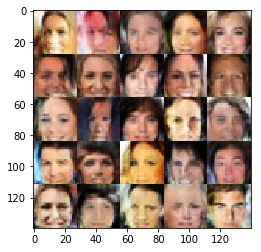

Epoch 1/1... Discriminator Loss: 0.9475... Generator Loss: 0.9720
Epoch 1/1... Discriminator Loss: 0.8635... Generator Loss: 1.2102
Epoch 1/1... Discriminator Loss: 0.8955... Generator Loss: 0.9998
Epoch 1/1... Discriminator Loss: 0.9115... Generator Loss: 1.1424
Epoch 1/1... Discriminator Loss: 1.3706... Generator Loss: 0.5341
Epoch 1/1... Discriminator Loss: 1.2990... Generator Loss: 0.6029
Epoch 1/1... Discriminator Loss: 1.0706... Generator Loss: 0.8189
Epoch 1/1... Discriminator Loss: 1.2886... Generator Loss: 0.5811
Epoch 1/1... Discriminator Loss: 1.4124... Generator Loss: 0.4857
Epoch 1/1... Discriminator Loss: 1.5751... Generator Loss: 0.4138


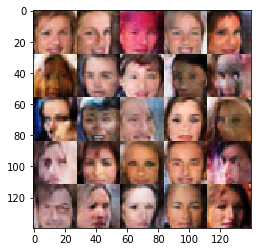

Epoch 1/1... Discriminator Loss: 1.3475... Generator Loss: 0.5833
Epoch 1/1... Discriminator Loss: 0.7893... Generator Loss: 1.4496
Epoch 1/1... Discriminator Loss: 1.2960... Generator Loss: 0.5469
Epoch 1/1... Discriminator Loss: 1.4117... Generator Loss: 0.5092
Epoch 1/1... Discriminator Loss: 1.2017... Generator Loss: 0.6362
Epoch 1/1... Discriminator Loss: 1.1928... Generator Loss: 0.6394
Epoch 1/1... Discriminator Loss: 1.3510... Generator Loss: 0.6429
Epoch 1/1... Discriminator Loss: 1.4339... Generator Loss: 0.5288
Epoch 1/1... Discriminator Loss: 1.1234... Generator Loss: 0.9284
Epoch 1/1... Discriminator Loss: 1.5632... Generator Loss: 0.3866


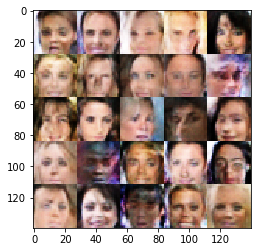

Epoch 1/1... Discriminator Loss: 1.1345... Generator Loss: 0.8871
Epoch 1/1... Discriminator Loss: 0.9975... Generator Loss: 1.1807
Epoch 1/1... Discriminator Loss: 1.0002... Generator Loss: 1.0245
Epoch 1/1... Discriminator Loss: 1.2804... Generator Loss: 0.5881
Epoch 1/1... Discriminator Loss: 0.8742... Generator Loss: 1.0019
Epoch 1/1... Discriminator Loss: 1.3783... Generator Loss: 0.5540
Epoch 1/1... Discriminator Loss: 1.3698... Generator Loss: 0.6192
Epoch 1/1... Discriminator Loss: 0.8688... Generator Loss: 1.1250
Epoch 1/1... Discriminator Loss: 1.0568... Generator Loss: 0.8868
Epoch 1/1... Discriminator Loss: 1.2939... Generator Loss: 0.5354


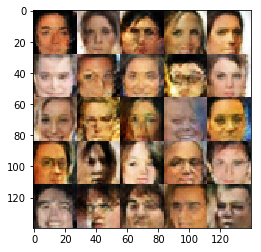

Epoch 1/1... Discriminator Loss: 1.1850... Generator Loss: 0.7017
Epoch 1/1... Discriminator Loss: 1.4485... Generator Loss: 0.4552
Epoch 1/1... Discriminator Loss: 1.0237... Generator Loss: 1.0154
Epoch 1/1... Discriminator Loss: 0.8771... Generator Loss: 1.0657
Epoch 1/1... Discriminator Loss: 1.1070... Generator Loss: 0.7913
Epoch 1/1... Discriminator Loss: 1.3963... Generator Loss: 0.5100
Epoch 1/1... Discriminator Loss: 1.0851... Generator Loss: 0.7330
Epoch 1/1... Discriminator Loss: 0.9563... Generator Loss: 1.0096
Epoch 1/1... Discriminator Loss: 1.6195... Generator Loss: 0.3973
Epoch 1/1... Discriminator Loss: 1.5603... Generator Loss: 0.4292


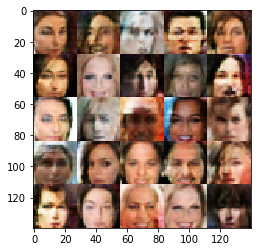

Epoch 1/1... Discriminator Loss: 0.9036... Generator Loss: 1.0449
Epoch 1/1... Discriminator Loss: 1.1280... Generator Loss: 1.9545
Epoch 1/1... Discriminator Loss: 0.8467... Generator Loss: 1.0934


In [14]:
batch_size = 32
z_dim = 256
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.